In [1]:
import numpy as np
import matplotlib.pyplot as plot
from scipy.stats import norm

In [11]:
# сам класс винеровского процесса
class WinerProcess:
    def __init__(self, precision=10000):
        self.precision = precision
        
        # наборы ksi_k для каждого отрезка разбиения 
        # (соответственно по precision штук)
        self.chunks = []
        self.chunk_count = 0  
        
        self.starts = [0.]  # значение процесса в началах отрезков
        self.max_time = 0.
        self._extend()

    
    def __str__(self):
        return str(self.starts)
    
    def _extend(self, times=1):
        for i in range(0, times):
            self.chunk_count += 1
            self.chunks.append(np.array(
                    norm.rvs(0, 1, size=self.precision)))
            self.starts.append(self._evaluate_x_t_in_chunk(np.pi, -1))
            self.max_time += np.pi
            
    def _extend_till(self, destination):
        while (destination >= self.max_time):
            self._extend()

    def _evaluate_x_t_in_chunk(self, t, chunk_i):
        # счтаем значение суммы в точке t in [0, pi] 
        # на конкретном отрезке
        x_t = self.chunks[chunk_i][0] * t / (np.pi ** 0.5) + \
              self.starts[chunk_i];
        # считаем сумму
        np_ks = np.array([range(1, self.precision)])
        pure_sum = np.sum(np.sin(np_ks * t ) / np_ks * \
                          self.chunks[chunk_i][1::1])
        x_t += pure_sum * (2 / np.pi) ** 0.5
        return x_t
    
    def _evaluate_x_t(self, t):
        # расширяем если нужно
        self._extend_till(t)
        chunk_i = int(np.floor(t / np.pi))
        return self._evaluate_x_t_in_chunk(t % np.pi, chunk_i);
    
    def __getitem__(self, times):
        return [self._evaluate_x_t(time) for time in times]

In [12]:
%%time
Wt = WinerProcess()
t = np.linspace(0, 10 ** 7, 10 ** 5)
# values = Wt[t]

CPU times: user 5.41 ms, sys: 2.56 ms, total: 7.97 ms
Wall time: 6.32 ms


Проблема в том, что может возникнуть переполнение памяти. Базовый алгоритм запоминает все случайные величины для всех блоков разбиения, считая, что его могут попросить посчитать значения процесса в уже пройденых блоках. Однако если рассматривать только упорядоченные моменты времени, то хранить все блоки и случайные величины не придется. Необходимо хранить только последний и пересчитывать(переиспользуя его память).

In [13]:
def evaluate_x_t_in_chunk(t, chunk, start_value):
    # счтаем значение суммы в точке t in [0, pi] на конкретном отрезке
    precision = len(chunk)
    x_t = chunk[0] * t / (np.pi ** 0.5) + start_value
    # считаем сумму
    np_ks = np.array([range(1, precision)])
    pure_sum = np.sum(np.sin(np_ks * t ) / np_ks * chunk[1::1])
    x_t += pure_sum * (2 / np.pi) ** 0.5
    return x_t

def winer_process_path(end_time, step, precision=10000):
    times = np.arange(0, end_time, step)
    start = 0
    end = np.pi
    start_value = 0
    norm_values = norm.rvs(0, 1, size=precision)
    values = []
    point = 0
    while point < len(times):
        while point < len(times) and start <= times[point] < end:
            values.append(evaluate_x_t_in_chunk(times[point] % np.pi, 
                                                norm_values, 
                                                start_value))
            point += 1
        start += np.pi
        end += np.pi
        old =start_value
        start_value = evaluate_x_t_in_chunk(np.pi, norm_values, old)
        norm_values = norm.rvs(0, 1, size=precision)
    return times, values    

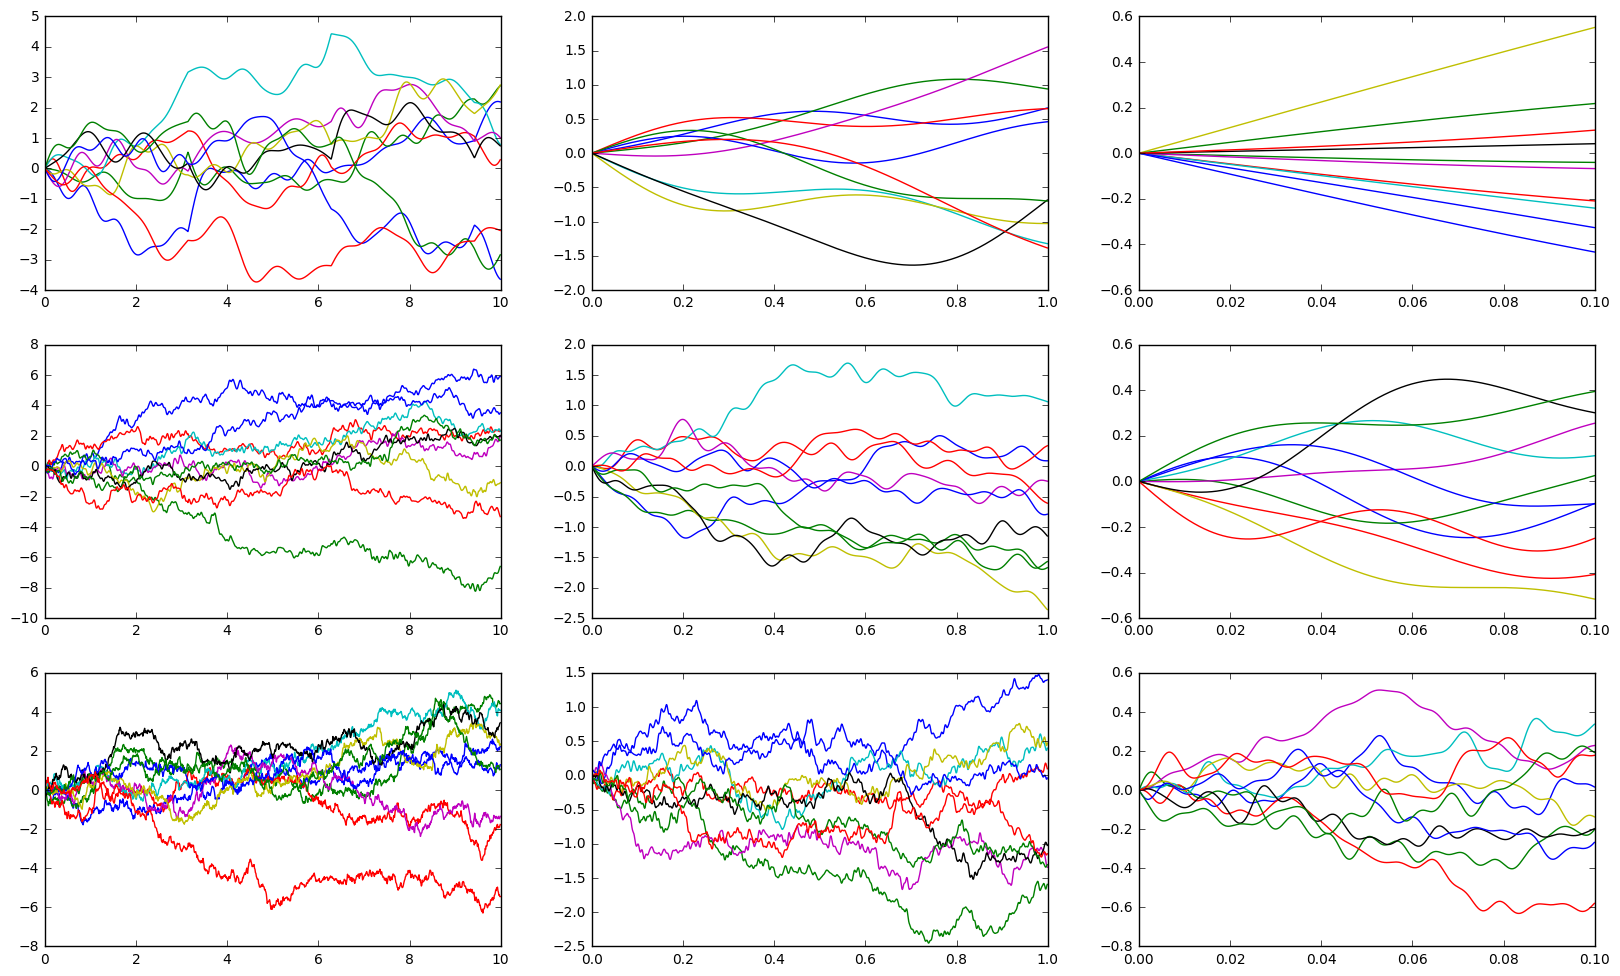

CPU times: user 10.6 s, sys: 227 ms, total: 10.8 s
Wall time: 11.1 s


In [5]:
%%time

plot.figure(figsize=(20, 12))
for i in range(3):
    for j in range(3):
        for k in range(10):
            plot.subplot(3, 3, i * 3 + j + 1)
            times, values = winer_process_path([10., 1., 0.1][j], 
                                               [0.01, 0.001, 0.0001][j], 
                                               [10, 100, 1000][i])
            plot.plot(times, values)
plot.show()

По графикам видно, что при недостатке точности приближения(маленьких precision) график процесса начинает сглаживаться, и чем меньше интервал, тем это заметнее(логично, ведь на больших интервалах график сжимается и гладкие кривые уже не выглядят таковыми)

In [7]:
%time times, values = winer_process_path(5000, 0.1)

CPU times: user 1min 32s, sys: 9.91 s, total: 1min 42s
Wall time: 1min 43s
